In [2]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# plt styles
matplotlib.style.use("default")
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

In [4]:
fits = fit_all_peaks_in_all_orders(correct_errors=True)

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


In [60]:
OG_fits = fit_all_peaks_in_all_orders(correct_errors=False)

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


In [61]:
def to_dataframe(r):
    dfs = []
    for order_results in r:
        order = order_results[0]
        peak_fits = order_results[1]
        wavel_true, wavel_true_n = order_results[2][:, 0], order_results[2][:, 1]
        wavel_ThAr = order_results[3]
        data = {
            'order': order,
            'mu': peak_fits[:, 2],
            'chi2': peak_fits[:, 8],
            'wavel_true': wavel_true,
            'wavel_true_n': wavel_true_n,
            "wavel_ThAr": wavel_ThAr,
            'rgb': [wav2RGB(x) for x in wavel_true]
        }
        dfs.append(pd.DataFrame(data))
    df = pd.concat(dfs)
    return df


df = to_dataframe(fits)
df_og = to_dataframe(OG_fits)

In [79]:
def give_me_that_res_for(df, odd_or_even, filter_chi2=100):

    res = []
    for o in np.arange(40, 85):
    
        mdf = df[df.order == o]
        mdf = mdf[mdf.chi2 < filter_chi2]

        x = np.asarray(mdf.mu)
        y = np.asarray(mdf.wavel_true)

        if len(x) < 10:
            continue

        if "odd" in odd_or_even:
            x = x[1:]
            y = y[1:]

        x1, y1 = x[::2], y[::2]
        x2, y2 = x[1::2], y[1::2]
        
        # x2 = x2[1:-1]
        # y2 = y2[1:-1]

        f = interp1d(x1, y1, kind="cubic")

        order_res = []
        for X2, Y2 in zip(x2, y2):
            try:
                # diff = Y2 - f(X2)
                c = 299792458 # m/s
                diff = (f(X2) - Y2)/Y2 * c
                order_res.append(diff)
            except ValueError:
                pass
        
        res.append(order_res)

    res = np.concatenate(res)
    return res

def give_me_that_res(df, filter_chi2=100):
    res1 = give_me_that_res_for(df, "even", filter_chi2)
    res2 = give_me_that_res_for(df, "odd", filter_chi2)
    residuals = np.concatenate([res1, res2])
    return residuals

10.747226325803318 -0.002798300475960934 13215
14.44788577045576 0.09150847035492535 8054


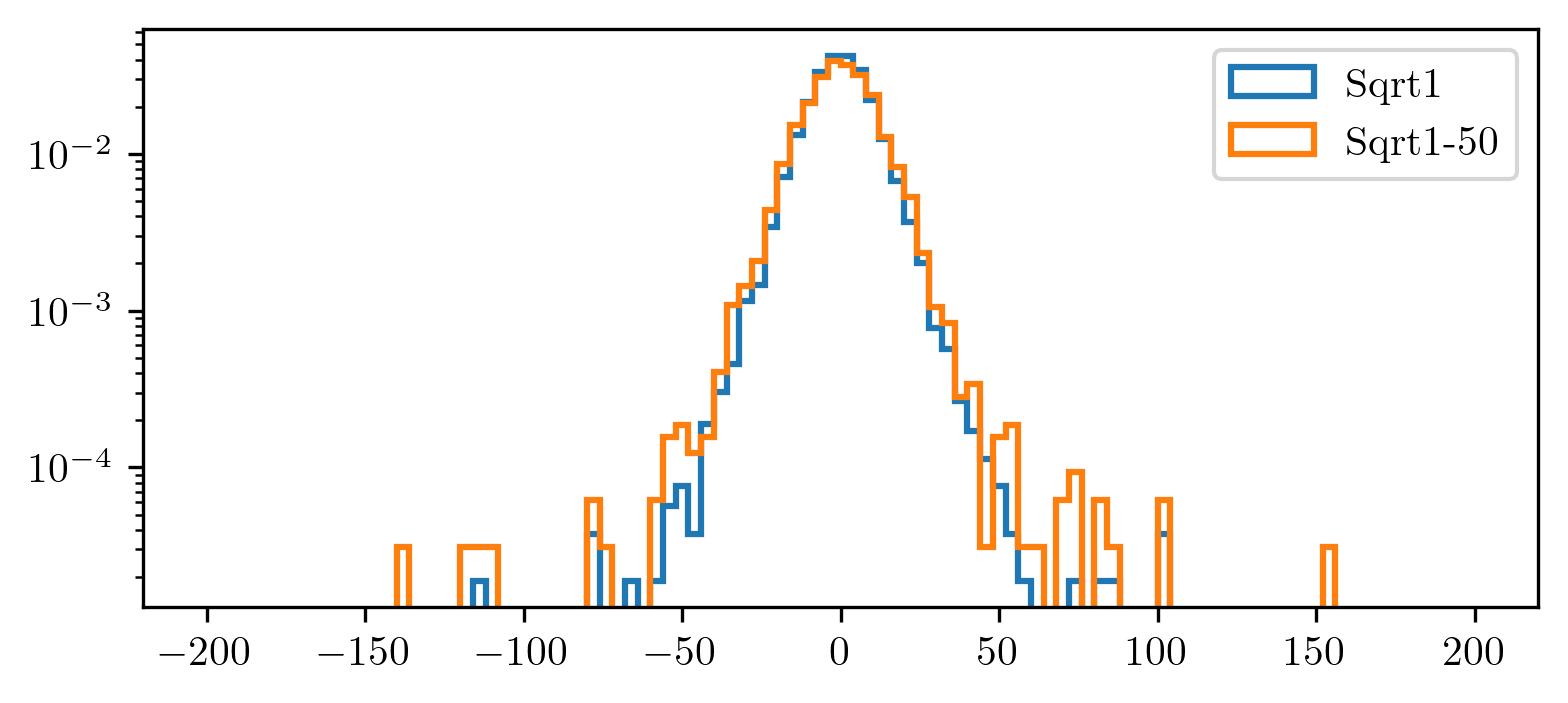

In [96]:
def plot_hist(x, label, range=(-200, 200)):
    plt.hist(x, bins=100, range=range, density=True, histtype="step", lw=1.5, label=label);    

plt.figure(figsize=(6,2.5))

# residuals = give_me_that_res(df)
# print(compute_rms(residuals), np.mean(residuals), len(residuals))
# plot_hist(residuals, "Sqrt3")

residuals = give_me_that_res(df_og)
print(compute_rms(residuals), np.mean(residuals), len(residuals))
plot_hist(residuals, "Sqrt1")

residuals = give_me_that_res(df_og, 50)
print(compute_rms(residuals), np.mean(residuals), len(residuals))
plot_hist(residuals, "Sqrt1-50")


plt.yscale("log")
plt.legend()

In [42]:
from sklearn.model_selection import train_test_split

def give_me_that_res_90(random_state=25):

    res = []
    for o in np.arange(0, 85):

        mdf = df[df.order == o]
        if len(mdf) < 10:
            continue

        mdf = mdf[mdf.chi2 < 100]

        training_data, testing_data = train_test_split(mdf, test_size=0.1, random_state=random_state)

        x1 = training_data.mu
        y1 = training_data.wavel_true
        x2 = testing_data.mu
        y2 = testing_data.wavel_true

        if len(x1) < 10:
            continue

        f = interp1d(x1, y1, kind="cubic")

        order_res = []
        for X2, Y2 in zip(x2, y2):
            try:
                # diff = Y2 - f(X2)
                c = 299792458 # m/s
                diff = (f(X2) - Y2)/Y2 * c
                order_res.append(diff)
            except ValueError:
                pass
        
        res.append(order_res)

    res = np.concatenate(res)
    return res


residuals = give_me_that_res_90()
compute_rms(residuals), np.mean(residuals), len(residuals)

(11.77483764147114, -0.3176093109283516, 1667)

In [27]:
means = []
for random_state in np.arange(0, 1000):
    residuals = give_me_that_res_90(random_state)
    means.append(np.mean(residuals))

Text(0.5, 0, 'Residual mean [m/s]')

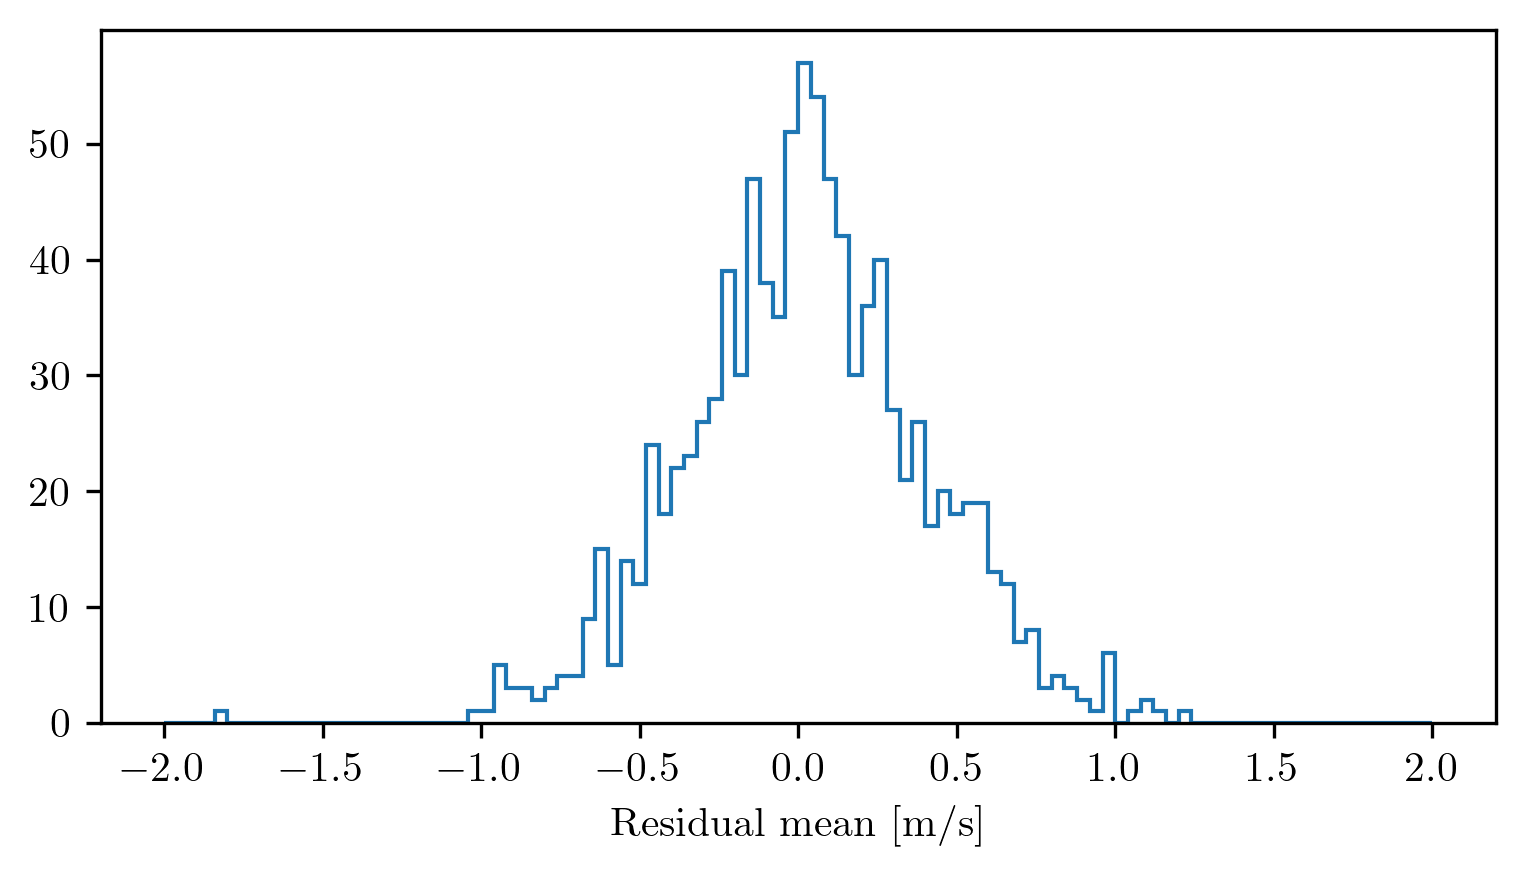

In [47]:
plt.figure(figsize=(6,3))
plt.hist(means, range=(-2, 2), bins=100, histtype="step");
plt.xlabel("Residual mean [m/s]")

The average of the residuals fluctuates wildly when changing the random_state, the random selection of 90 percent of the points. Seems like a bad way to measure things .... 

In [ ]:
plt.hist(residuals, bins=100, range=(-60, 60), density=True, histtype="step", color="k", lw=1.5);